# Bootstrap - Code examples

In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t
import math
from numpy import mean, std, sqrt
from IPython.core.display import HTML
import seaborn as sns

### Example of computing confidence intervals

In [61]:
#Using T-test	of	comparing	a	sample	mean,	 ,	with	the true	 mean,	 μx,	 we	 can	 determine	 a	 confidence	 interval	 for	 the	 true	 mean,	 related	 to	 a specified	probability,	given	the	sample	mean	and	the	unbiased	sample	standard	deviation.
def tConfInterval(samples, confidence, isOneSided=True):
    n = len(samples)
    sampleMean = np.mean(samples)
    sampleStdDev = np.std(samples, ddof=1) # Unbiased estimate
    if not isOneSided:
        confidence = 0.5 * (1+confidence)
    
    interval = t(n-1).ppf(confidence) * sampleStdDev / sqrt(n)
    return sampleMean, interval

from numpy import array
samples = array([1.752, 1.818, 1.597, 1.697, 1.644, 1.593,
1.878, 1.648, 1.819, 1.794, 1.745, 1.827])
sMean, intvl = tConfInterval(samples, 0.95, isOneSided=False)
print('Sample mean: %.3f, 95%% interval:%.4f' % (sMean, 2*intvl))


Sample mean: 1.734, 95% interval:0.1231


In [62]:


# Verify by using stats Student-t distribution
CI=stats.t.interval(alpha = 0.95,              # Confidence level
                 df= 11,                    # Degrees of freedom
                 loc = np.mean(samples),         # Sample mean
                 scale = np.std(samples,ddof=1)/sqrt(n))             # Standard deviation estimate
CI[1]-CI[0]


0.12309825285710252

(0, 1)

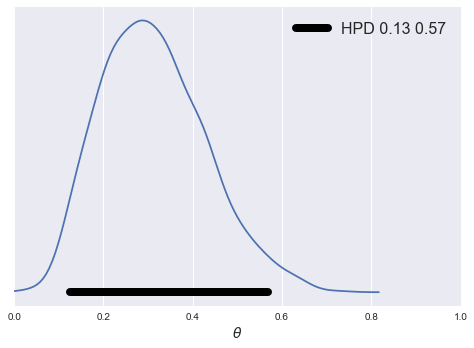

In [63]:
#Confidence intervals from percentiles

def naive_hpd(post):
    sns.kdeplot(post)
    HPD = np.percentile(post, [2.5, 97.5])
    plt.plot(HPD, [0, 0], label='HPD {:.2f} {:.2f}'.format(*HPD), 
      linewidth=8, color='k')
    plt.legend(fontsize=16);
    plt.xlabel(r"$\theta$", fontsize=14)
    plt.gca().axes.get_yaxis().set_ticks([])

    
np.random.seed(1)
post = stats.beta.rvs(5, 11, size=1000)
naive_hpd(post)
plt.xlim(0, 1)

### Bootstrap
This material is copied from Resampling Methods and Missing Data Jupyter Notebook 

We regard S as an "estimate" of population P

> population : sample :: sample : bootstrap sample

The idea is to generate replicate bootstrap samples:

<div style="font-size: 120%;">  
$$S^* = \{S_1^*, S_2^*, \ldots, S_R^*\}$$
</div>

Compute statistic $t$ (estimate) for each bootstrap sample:

<div style="font-size: 120%;">  
$$T_i^* = t(S^*)$$
</div>

Let's simulate this for estimating the mean of our sample.

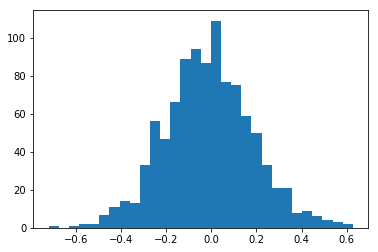

In [16]:
# Sample size
n = 30
# Bootstrap replicates
R = 1000

# Original sample (n=10)
data = np.random.normal(size=n)

# 1000 bootstrap samples of size 10
s = [data[np.random.randint(0,n,n)].mean() for i in range(R)]
_ = plt.hist(s, bins=30)

### Bootstrap Estimates

From our bootstrapped samples, we can extract *estimates* of the expectation and its variance:

$$\bar{T}^* = \hat{E}(T^*) = \frac{\sum_i T_i^*}{R}$$

$$\hat{\text{Var}}(T^*) = \frac{\sum_i (T_i^* - \bar{T}^*)^2}{R-1}$$


In [17]:
boot_mean = np.sum(s)/R
boot_mean

-0.013290318881548224

In [18]:
boot_mean_var = ((np.array(s) - boot_mean) ** 2).sum() / (R-1)
boot_mean_var

0.038100806812335117

Since we have estimated the expectation of the bootstrapped statistics, we can estimate the **bias** of T:

$$\hat{B}^* = \bar{T}^* - T$$


In [19]:
boot_mean - np.mean(data)

0.0045965570936563772

### Bootstrap error

There are two sources of error in bootstrap estimates:

1. **Sampling error** from the selection of $S$.
2. **Bootstrap error** from failing to enumerate all possible bootstrap samples.

For the sake of accuracy, it is prudent to choose at least R=1000

### Bootstrap Percentile Intervals

An attractive feature of bootstrap statistics is the ease with which you can obtain an estimate of **uncertainty** for a given statistic. We simply use the empirical quantiles of the bootstrapped statistics to obtain percentiles corresponding to a **confidence interval** of interest.

This employs the *ordered* bootstrap replicates:

$$T_{(1)}^*, T_{(2)}^*, \ldots, T_{(R)}^*$$

Simply extract the $100(\alpha/2)$ and $100(1-\alpha/2)$ percentiles:

$$T_{[(R+1)\alpha/2]}^* \lt \theta \lt T_{[(R+1)(1-\alpha/2)]}^*$$

In [20]:
s_sorted = np.sort(s)
s_sorted[:10]

array([-0.7213747 , -0.59417655, -0.54452212, -0.54298132, -0.51129857,
       -0.51044239, -0.48927998, -0.47996392, -0.479519  , -0.47473556])

In [21]:
s_sorted[-10:]

array([ 0.48717373,  0.49453838,  0.51804877,  0.52423522,  0.5323516 ,
        0.53834154,  0.55382994,  0.57664075,  0.59823797,  0.62756617])

In [29]:
alpha = 0.05
s_sorted[[int((R+1)*alpha/2), int((R+1)*(1-alpha/2))]]

array([-0.39743807,  0.39903115])

### Linear regression


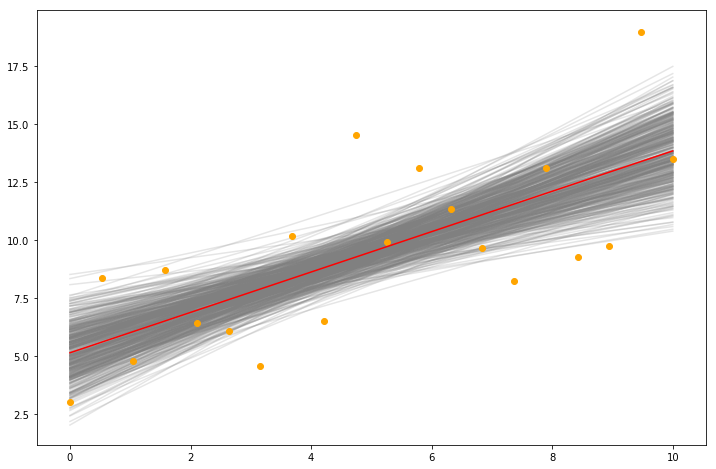

In [1]:
#From https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create toy data 
x = np.linspace(0, 10, 20)
y = x + (np.random.rand(len(x)) * 10)

# Extend x data to contain another row vector of 1s
X = np.vstack([x, np.ones(len(x))]).T

plt.figure(figsize=(12,8))
for i in range(0, 500):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    X_samples = X[sample_index]
    y_samples = y[sample_index]    

    lr = LinearRegression()
    lr.fit(X_samples, y_samples)
    plt.plot(x, lr.predict(X), color='grey', alpha=0.2, zorder=1)

plt.scatter(x,y, marker='o', color='orange', zorder=4)

lr = LinearRegression()
lr.fit(X, y)
plt.plot(x, lr.predict(X), color='red', zorder=5)

## Courses



+ Stat 104 - “Re-sampling methods in statistical modeling” at http://www.ulb.ac.be/di/map/gbonte/Stat104.html#contenu
Resampling and repeated simulations are used to calculate standard errors, confidence intervals and significance tests or, more in general, to assess the quality of a statistical models
+ Computational Statistics II Tutorial in Python at https://github.com/fonnesbeck/scipy2015_tutorial/blob/master/notebooks/4.%20Resampling%20Methods%20and%20Missing%20Data.ipynb 
Data preparation, Density estimation, Regression modeling and model selection, 
Resampling methods and missing data imputation, Bayesian statistics
